In [1]:
import os 
import pickle 
from natsort import natsorted

def load_data_as_dict(directory_path):
    """
    Return pickle file in directory_path as a list. 
    Also returns a list of all the unique id's in the dataset. 
    Why do we need unique id? 
        Lets say a task is randomly mapped 100 times. 
        All the 100 data (dict in pickle file) will have the same id. 
        So it is easier to retrieve all the mapping for a single task
    """
    entries = os.listdir(directory_path)
    files = natsorted([entry for entry in entries if os.path.isfile(os.path.join(directory_path, entry))])

    list_of_dicts = []
    list_of_uuids = []

    for file_name in files:
        file_path = os.path.join(directory_path, file_name)

        with open(file_path, 'rb') as file:
            data_dict = pickle.load(file)
            list_of_dicts.append(data_dict)

            uuid = data_dict['task_dag'].id

            if uuid not in list_of_uuids:
                list_of_uuids.append(uuid)

    return list_of_dicts, list_of_uuids

In [2]:

single_mapping_data, _ = load_data_as_dict('data/task_7')
print(f"Size of Dataset {len(single_mapping_data)}")

Size of Dataset 34633


In [3]:
from networkx.algorithms.isomorphism import GraphMatcher

"""
Two graphs which contain the same number of 
graph vertices connected in the same way 
are said to be isomorphic. 
"""
def isomorphic(graph1, graph2):
    GM = GraphMatcher(graph1, graph2)
    return GM.is_isomorphic()

def group_by_isomorphism(data):
    """
    Check if two graphs in data is isomorphic, 
    if they are, put them into the same list. 

    Returns 
        1. isomorphic_groups contains the list of all similar graphs. (not usefule for us)
        2. list_of_same_graphs (self explanatory)
    """
    isomorphic_groups = []
    list_of_same_graphs = []

    for item in data:
        graph = item['task_dag'].graph
        added_to_group = False
        
        # Iterate through existing isomorphic groups
        for existing_group, existing_data_group in zip(isomorphic_groups, list_of_same_graphs):
            if isomorphic(graph, existing_group[0]):
                existing_group.append(graph)
                existing_data_group.append(item)
                added_to_group = True
                break

        if not added_to_group:
            # If no isomorphic group found, create a new one
            isomorphic_groups.append([graph])
            list_of_same_graphs.append([item])

    return isomorphic_groups, list_of_same_graphs

_, list_of_same_graphs = group_by_isomorphism(single_mapping_data)


"""
list_of_same_graphs.
Each unique graph is a list with all its occurences
"""
print("Number of Unique Tasks", len(list_of_same_graphs))


Number of Unique Tasks 555


Number of similar graphs for each unique task: [312, 124, 82, 5, 452, 358, 674, 206, 11739, 35, 110, 324, 26, 116, 75, 83, 383, 125, 6, 14, 25, 122, 57, 129, 224, 132, 45, 68, 287, 202, 125, 22, 162, 71, 67, 348, 77, 92, 203, 157, 132, 262, 102, 34, 52, 240, 192, 120, 20, 45, 160, 111, 51, 15, 54, 16, 284, 327, 184, 26, 11, 126, 125, 335, 117, 33, 212, 276, 265, 66, 51, 83, 102, 20, 77, 143, 50, 61, 54, 44, 26, 17, 40, 83, 115, 14, 10, 84, 371, 130, 31, 58, 63, 2, 87, 19, 61, 89, 7, 257, 21, 69, 65, 6, 148, 147, 30, 275, 62, 374, 76, 1, 418, 63, 33, 150, 25, 93, 19, 62, 23, 84, 192, 124, 87, 138, 95, 74, 46, 75, 63, 149, 189, 19, 130, 238, 87, 4, 24, 197, 63, 73, 11, 8, 6, 85, 68, 159, 181, 75, 6, 60, 57, 112, 2, 32, 28, 10, 24, 279, 14, 108, 24, 2, 63, 66, 1, 18, 74, 68, 16, 14, 37, 82, 102, 80, 17, 98, 131, 5, 91, 1, 67, 3, 38, 44, 79, 45, 18, 44, 63, 26, 6, 3, 67, 89, 4, 13, 66, 1, 58, 17, 64, 90, 22, 16, 5, 9, 17, 2, 25, 33, 17, 75, 31, 26, 4, 14, 3, 113, 56, 12, 20, 77, 11, 37, 23

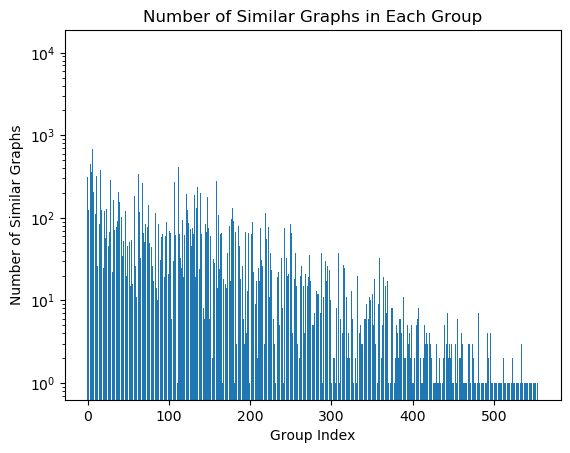

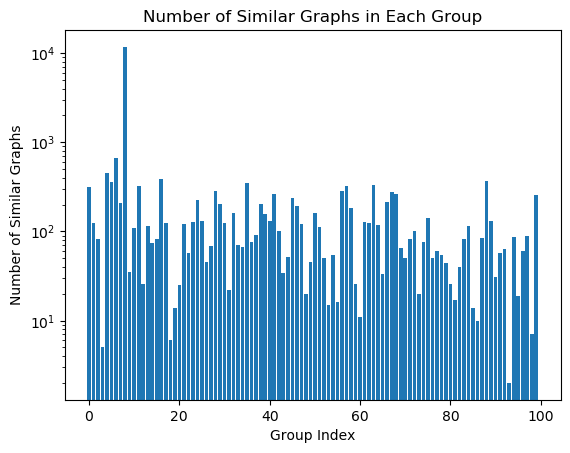

In [7]:
num_similar_graph = [len(group) for group in list_of_same_graphs] 
print("Number of similar graphs for each unique task:", num_similar_graph)

import matplotlib.pyplot as plt
plt.bar(range(len(num_similar_graph)), num_similar_graph)
plt.yscale('log')
plt.xlabel('Group Index')
plt.ylabel('Number of Similar Graphs')
plt.title('Number of Similar Graphs in Each Group')
plt.show()

num_similar_graph = num_similar_graph[0:100]
plt.bar(range(len(num_similar_graph)), num_similar_graph)
plt.yscale('log')
plt.xlabel('Group Index')
plt.ylabel('Number of Similar Graphs')
plt.title('Number of Similar Graphs in Each Group')
plt.show()

Index of the group with the maximum occurrences: 8


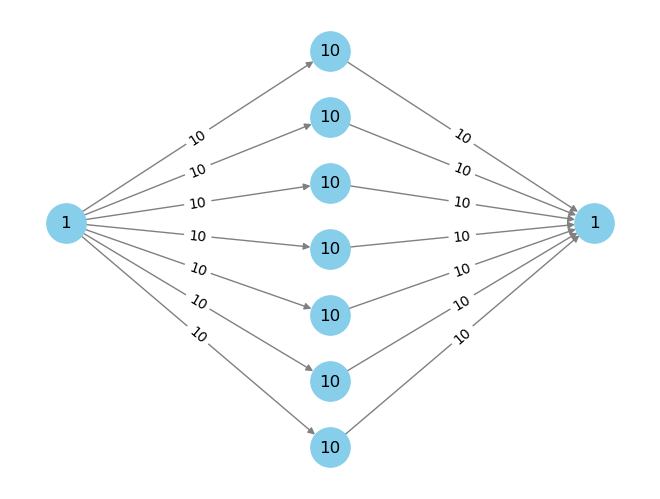

Min: 2666.0, Max: 3595.0
25th Percentile 2675.0
75th Percentile 2961.0


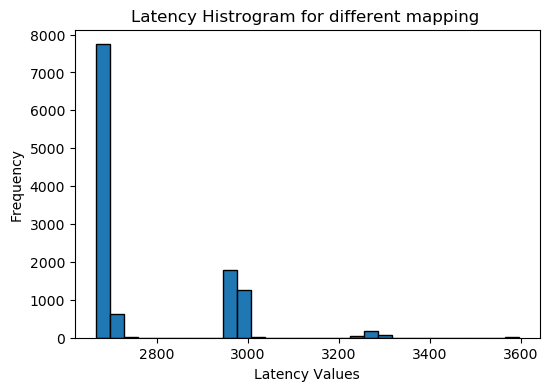

In [16]:
max_occurrences_index = num_similar_graph.index(max(num_similar_graph))
print("Index of the group with the maximum occurrences:", max_occurrences_index)

most_freq_graph_list = list_of_same_graphs[max_occurrences_index]
most_freq_graph_list[0]['task_dag'].plot()

import numpy as np

def plot_latency_histogram(graph_list, fig_width=6, fig_height=4):
    latency_list = []

    for task in graph_list:
        latency = task['network_processing_time']
        latency_list.append(float(latency))

    print(f"Min: {np.min(latency_list)}, Max: {np.max(latency_list)}")
    print(f"25th Percentile {np.percentile(latency_list, 25)}")
    print(f"75th Percentile {np.percentile(latency_list, 75)}")

    plt.figure(figsize=(fig_width, fig_height))
    plt.hist(latency_list, bins=30, edgecolor='black')
    plt.title('Latency Histrogram for different mapping ')
    plt.xlabel('Latency Values')
    plt.ylabel('Frequency')
    plt.show()

plot_latency_histogram(most_freq_graph_list)
